# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.chdir("../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=1,
          tokenizer_version=1,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=7,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          print_freq=6,
          random_seed=20,
          scheduler='cosine',
          stride=192,
          train=True,
          train_folds=[0, 1, 2, 3, 4, 5, 6, 7],
          weight_decay=0.01)


In [5]:
seed_everything()

### Setting Up WandB

In [6]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
WANDB_NAME = f"{config.model}-{config.max_length}"

In [7]:
wandb.login(key=os.environ.get('WANDB_NOTEBOOK_NAME'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin


## 📖 Definitions

### 🌎 Global Variables

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 🛠️ Functions

In [9]:
def train_loop(fold):
    print(f"========== Fold: {fold} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold)
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(train_loader, device)

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    # class_weights = torch.tensor([0.928, 0.773, 0.637, 0.727, 0.944, 1.0]).to(device)
    # class_weights = torch.tensor([1.0, 0.75, 0.5, 0.75, 1.0, 1.5]).to(device)
    class_weights = torch.tensor([1.0] * 6).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, predictions = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)

        wandb.log(
            {
                f"eval/eval_loss_f{fold}": avg_val_loss,
                f"eval/qwk_score_f{fold}": score,
            }
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        print(f"Epoch {epoch+1} - Score: {score:.4f}")

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                Paths.MODEL_OUTPUT_PATH
                + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
            )

    predictions = torch.load(
        Paths.MODEL_OUTPUT_PATH
        + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]
    valid_fold["pred_score"] = predictions

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

    return valid_fold

In [10]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [11]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_loop(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 training ==========


Validation: 100%|██████████| 96/96 [00:15<00:00,  6.06valid_batch/s]


Epoch 1 - avg_train_loss: 1.1514  avg_val_loss: 0.9624  time: 162s
Epoch 1 - Score: 0.6834
Epoch 1 - Save Best Score: 0.6834 Model


Validation: 100%|██████████| 96/96 [00:14<00:00,  6.61valid_batch/s]


Epoch 2 - avg_train_loss: 0.9378  avg_val_loss: 0.9486  time: 160s
Epoch 2 - Score: 0.6994
Epoch 2 - Save Best Score: 0.6994 Model
========== Fold: 0 result ==========
Score: 0.6994
========== Fold: 1 training ==========


Validation: 100%|██████████| 95/95 [00:14<00:00,  6.60valid_batch/s]


Epoch 1 - avg_train_loss: 1.1423  avg_val_loss: 1.0281  time: 149s
Epoch 1 - Score: 0.6916
Epoch 1 - Save Best Score: 0.6916 Model


Validation: 100%|██████████| 95/95 [00:14<00:00,  6.60valid_batch/s]


Epoch 2 - avg_train_loss: 0.9089  avg_val_loss: 1.0370  time: 148s
Epoch 2 - Score: 0.6808
========== Fold: 1 result ==========
Score: 0.6916
========== Fold: 2 training ==========


Validation: 100%|██████████| 110/110 [00:16<00:00,  6.57valid_batch/s]


Epoch 1 - avg_train_loss: 1.1731  avg_val_loss: 0.9144  time: 146s
Epoch 1 - Score: 0.7019
Epoch 1 - Save Best Score: 0.7019 Model


Validation: 100%|██████████| 110/110 [00:16<00:00,  6.59valid_batch/s]


Epoch 2 - avg_train_loss: 0.9224  avg_val_loss: 0.8870  time: 146s
Epoch 2 - Score: 0.6965
========== Fold: 2 result ==========
Score: 0.7019
========== Fold: 3 training ==========


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.57valid_batch/s]


Epoch 1 - avg_train_loss: 1.1224  avg_val_loss: 1.2658  time: 153s
Epoch 1 - Score: 0.5189
Epoch 1 - Save Best Score: 0.5189 Model


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.57valid_batch/s]


Epoch 2 - avg_train_loss: 0.9031  avg_val_loss: 1.2222  time: 153s
Epoch 2 - Score: 0.5751
Epoch 2 - Save Best Score: 0.5751 Model
========== Fold: 3 result ==========
Score: 0.5751
========== Fold: 4 training ==========


Validation: 100%|██████████| 52/52 [00:07<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.1443  avg_val_loss: 1.0787  time: 155s
Epoch 1 - Score: 0.4177
Epoch 1 - Save Best Score: 0.4177 Model


Validation: 100%|██████████| 52/52 [00:07<00:00,  6.56valid_batch/s]


Epoch 2 - avg_train_loss: 0.9133  avg_val_loss: 0.9531  time: 155s
Epoch 2 - Score: 0.5284
Epoch 2 - Save Best Score: 0.5284 Model
========== Fold: 4 result ==========
Score: 0.5284
========== Fold: 5 training ==========


Validation: 100%|██████████| 62/62 [00:09<00:00,  6.54valid_batch/s]


Epoch 1 - avg_train_loss: 1.1283  avg_val_loss: 1.0284  time: 153s
Epoch 1 - Score: 0.6718
Epoch 1 - Save Best Score: 0.6718 Model


Validation: 100%|██████████| 62/62 [00:09<00:00,  6.54valid_batch/s]


Epoch 2 - avg_train_loss: 0.8733  avg_val_loss: 1.2063  time: 153s
Epoch 2 - Score: 0.6221
========== Fold: 5 result ==========
Score: 0.6718
========== Fold: 6 training ==========


Validation: 100%|██████████| 64/64 [00:09<00:00,  6.48valid_batch/s]


Epoch 1 - avg_train_loss: 1.1101  avg_val_loss: 1.1600  time: 153s
Epoch 1 - Score: 0.6480
Epoch 1 - Save Best Score: 0.6480 Model


Validation: 100%|██████████| 64/64 [00:09<00:00,  6.49valid_batch/s]


Epoch 2 - avg_train_loss: 0.9080  avg_val_loss: 1.0529  time: 153s
Epoch 2 - Score: 0.6916
Epoch 2 - Save Best Score: 0.6916 Model
========== Fold: 6 result ==========
Score: 0.6916
========== CV ==========
Score: 0.6859


In [12]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [13]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

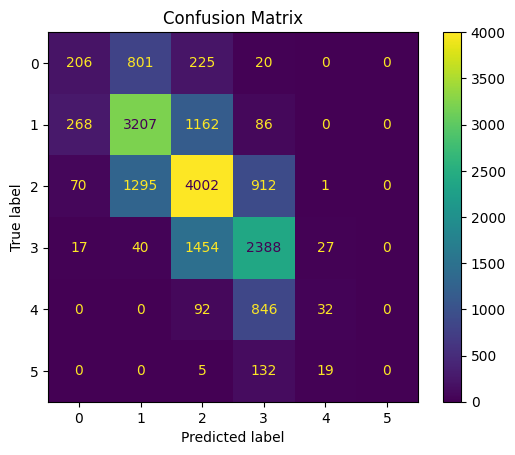

In [14]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [15]:
wandb.finish()

CV/qwk_score,▁
Fold 0/Accuracy,▇▄▁▃▇█
Fold 0/Error Rate,▂▅█▆▂▁
Fold 0/F1 Score,▃███▁
Fold 0/Precision,▇█▇▅▁
Fold 0/Recall,▂▆▆█▁▁
Fold 0/Sensitivity,▂▆▆█▁▁
Fold 0/Specificity,█▅▂▁██
Fold 1/Accuracy,▅▂▁▄▇█
Fold 1/Error Rate,▄▇█▅▂▁
Fold 1/F1 Score,▁██▆▂
